# <center> Эксперименты к 8 заданию по практикуму для 317 группы.

In [694]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gf
import bch
from importlib import reload
import pandas as pd
import time
reload(gf)
reload(bch)

<module 'bch' from '/home/anuar/Рабочий стол/Student/3 kurs/2 sem/Prack/task 8/bch.py'>

In [646]:
def generate_U(msg_cnt, k):
    U = np.zeros((msg_cnt, k)).astype('int')
    inds = np.arange(0, k)
    for i in range(msg_cnt):
        try:
            tmp = np.random.choice(inds, k)
            ind = np.unique(tmp)
        except:
            print(np.random.choice(inds, k))
        U[i, ind] = 1
    
    return U

def error_W(V, r):
    W = np.zeros(V.shape).astype('int')
    msg_cnt, n = V.shape
    inds = np.arange(0, n)
    for i in range(msg_cnt):
        error = np.zeros(n).astype('int')
        ind = np.random.choice(inds, r, replace=False)
        error[ind] = 1
        W[i, :] = V[i, :] ^ error
    
    return W

def check_decoder(V, V_hat):
    msg_cnt, n = V.shape
    res = np.zeros(msg_cnt).astype('int')
    res[np.all(V_hat < 0, axis=1)] = 2
    res[np.all(V_hat == V, axis=1)] = 1
    return res

def statistics(res):
    msg_cnt = res.shape[0]
    decode_error = np.where(res == 2)[0].shape[0]
    correct = np.where(res == 1)[0].shape[0]
    incorrect = np.where(res == 0)[0].shape[0]    
    return correct / msg_cnt, incorrect / msg_cnt, decode_error / msg_cnt

### <center> Проверка на правильность выполнения систематического кодирования.

In [707]:
n = 15
t = 3
msg_cnt = 10
bch_code = bch.BCH(n, t)
k = n - bch_code.m
U = generate_U(msg_cnt, k)
V = bch_code.encode(U)

In [708]:
print(U)

[[0 1 1 0 1]
 [1 0 1 1 0]
 [0 0 0 1 1]
 [1 0 0 0 1]
 [1 1 1 0 1]
 [0 1 0 0 1]
 [1 0 0 1 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [1 0 1 1 1]]


In [709]:
print(V[:, :k])

[[0 1 1 0 1]
 [1 0 1 1 0]
 [0 0 0 1 1]
 [1 0 0 0 1]
 [1 1 1 0 1]
 [0 1 0 0 1]
 [1 0 0 1 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [1 0 1 1 1]]


In [710]:
print(np.all(U == V[:, :k]))

True


### <center> Зависимость между скоростью кода и числом исправляемых ошибок для различных $n$.

In [665]:
t_val = {'15': np.arange(1, 10),
         '31': np.arange(1, 25),
         '63': np.arange(1, 45),
         '127': np.arange(1, 100)}
n_val = [15, 31, 63, 127]
r_val = []
for n in n_val:
    r_ = []
    for t in t_val[str(n)]:
        bch_code = bch.BCH(n, t)
        k = n - bch_code.m
        r_.append(k / n)
        
    r_val.append(r_)

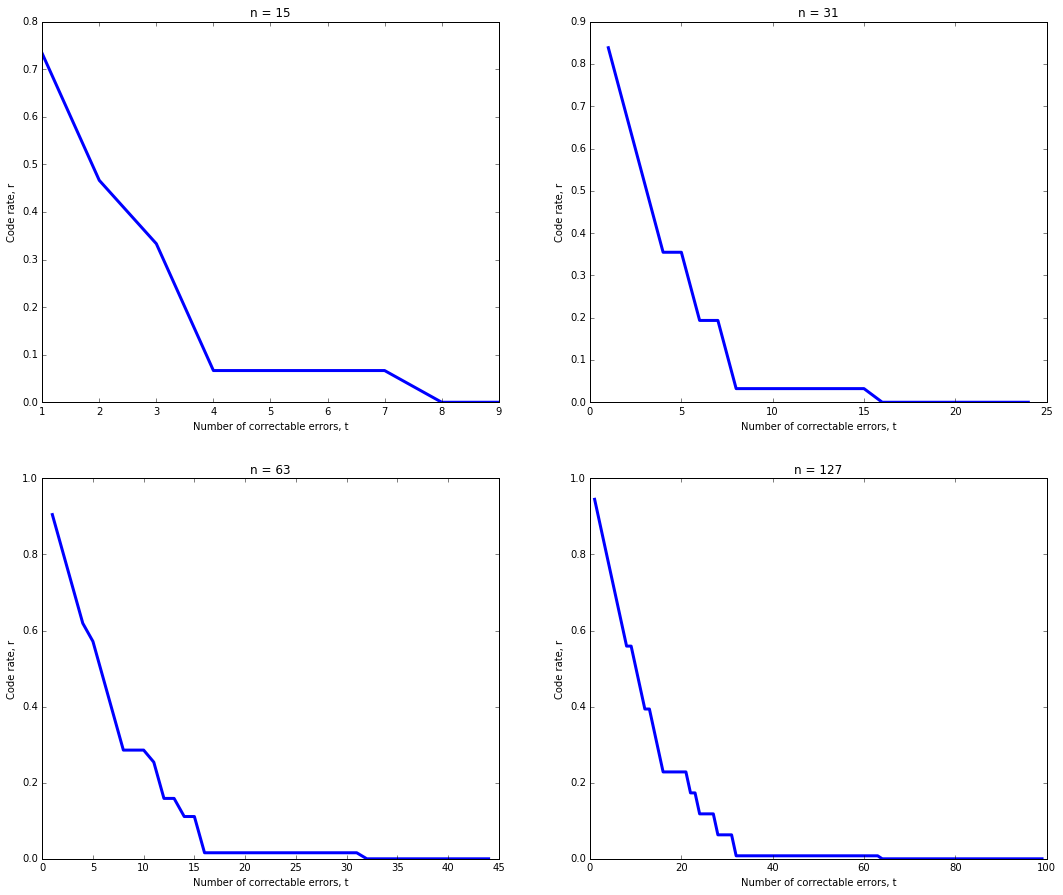

In [666]:
f, axxr = plt.subplots(2, 2)

f.set_figheight(15)
f.set_figwidth(18)
for i in range(2):
    for j in range(2):
        axxr[i, j].set_title("n = " + str(n_val[i * 2 + j]))
        axxr[i, j].plot(t_val[str(n_val[i * 2 + j])], 
                        r_val[i * 2 + j], lw=3)
        axxr[i, j].set_xlabel('Number of correctable errors, t')
        axxr[i, j].set_ylabel('Code rate, r')
plt.show()

### <center> Пример БЧХ-кода, для которого истинное минимальное расстояние больше, чем $2t + 1$.

In [713]:
n_val = [7, 15]
t_val = {"7": [1, 3],
         "15": [1, 2, 3, 4]}
column = ["n", "t", "2t + 1", "dist"]
table_dist = pd.DataFrame(columns=column)
for n in n_val:
    for t in t_val[str(n)]:
        row = [n, t, 2*t + 1]
        bch_code = bch.BCH(n, t)
        d = bch_code.dist()
        row.append(d)
        
        table_dist = table_dist.append(pd.Series(
                row,
                index=table_dist.columns),
                ignore_index=True)

In [714]:
table_dist

,n,t,2t + 1,dist
0,7.0,1.0,3.0,3.0
1,7.0,3.0,7.0,7.0
2,15.0,1.0,3.0,3.0
3,15.0,2.0,5.0,5.0
4,15.0,3.0,7.0,7.0
5,15.0,4.0,9.0,15.0


### <center> Сравнение двух методов декодирования по времени работы.

<font size=4, face="Times New Roman"> Количество ошибок равно $t$.

In [674]:
n_val = [7, 15, 31, 63, 63, 127, 127]
t_val = [1, 3, 4, 5, 8, 8, 11]
msg_val = [500, 500, 500, 500, 500, 500, 500]
column = ["n", "t", "Euclid decoder, time", "PGZ decoder, time"]
table_time = pd.DataFrame(columns=column)

In [675]:
for i in range(len(n_val)):
    msg_cnt = msg_val[i]
    n = n_val[i]
    t = t_val[i]
    row = [n, t]
    bch_code = bch.BCH(n, t)
    k = n - bch_code.m
    U = generate_U(msg_cnt, k)
    V = bch_code.encode(U)
    W = error_W(V, t)
    
    start = time.clock()
    V_hat = bch_code.decode(W, method='euclid')
    row.append(time.clock() - start)
    
    start = time.clock()
    V_hat = bch_code.decode(W, method='pgz')
    row.append(time.clock() - start)
    
    table_time = table_time.append(pd.Series(
                row,
                index=table_time.columns),
                ignore_index=True)

In [676]:
table_time

,n,t,"Euclid decoder, time","PGZ decoder, time"
0,7.0,1.0,0.580945,0.327488
1,15.0,3.0,2.067368,1.005466
2,31.0,4.0,3.535710,1.681343
3,63.0,5.0,5.545853,3.128824
4,63.0,8.0,10.280127,4.736844
5,127.0,8.0,12.705602,7.585843
6,127.0,11.0,20.582913,9.850387


In [679]:
n_val = [7, 15, 31, 63, 63, 127, 127]
t_val = [1, 3, 4, 5, 8, 8, 11]
msg_val = [500, 500, 500, 500, 500, 500, 500]
column = ["n", "t", "Euclid decoder, time", "PGZ decoder, time"]
table_time = pd.DataFrame(columns=column)

In [680]:
for i in range(len(n_val)):
    msg_cnt = msg_val[i]
    n = n_val[i]
    t = t_val[i]
    row = [n, t]
    bch_code = bch.BCH(n, t)
    k = n - bch_code.m
    U = generate_U(msg_cnt, k)
    V = bch_code.encode(U)
    W = error_W(V, 1)
    
    start = time.clock()
    V_hat = bch_code.decode(W, method='euclid')
    row.append(time.clock() - start)
    
    start = time.clock()
    V_hat = bch_code.decode(W, method='pgz')
    row.append(time.clock() - start)
    
    table_time = table_time.append(pd.Series(
                row,
                index=table_time.columns),
                ignore_index=True)

In [682]:
table_time

,n,t,"Euclid decoder, time","PGZ decoder, time"
0,7.0,1.0,0.588281,0.338834
1,15.0,3.0,1.169207,0.909572
2,31.0,4.0,1.739895,1.578275
3,63.0,5.0,3.003512,2.793846
4,63.0,8.0,3.958691,3.926208
5,127.0,8.0,6.288400,6.462221
6,127.0,11.0,8.696548,8.459977


### <center> Оценка доли правильно раскодированных, ошибочно раскодированных сообщений и отказов от декодирования.

<font size=4, face="Times New Roman"> Необходимо проверить долю правильно исправленных, ошибочно исправленных ошибок и долю отказов от декодирования в зависимости от $r$. В эксперименте приводятся результаты для количества сообщений равного 600.

In [689]:
n_val = [7, 15, 31, 63, 63, 127, 127]#[10, 20, 30, 40, 50, 
t_val = [1, 3, 4, 5, 8, 8, 11] #[2, 3, 4, 5, 5, 
msg_val = [10, 50, 100, 200, 200, 500, 500]#[50, 100, 150, 200, 500, 
column = ["Messages", "n", "t", 
         "Correct, r<=t", "Incorrect, r<=t", "Decode Error, r<=t"
         , "Correct, r>t", "Incorrect, r>t", "Decode Error, r>t"]
table_stats = pd.DataFrame(columns=column)

In [690]:
for i in range(len(n_val)):
    msg_cnt = msg_val[i]
    n = n_val[i]
    t = t_val[i]
    row = [msg_cnt, n, t]
    bch_code = bch.BCH(n, t)
    k = n - bch_code.m
    U = generate_U(msg_cnt, k)
    V = bch_code.encode(U)
    r_val = np.arange(1, t + 1)
    corr, incorr, dec_error = 0., 0., 0.
    
    for r in r_val:
        W = error_W(V, r)
        V_hat = bch_code.decode(W, method='pgz')
        res = check_decoder(V, V_hat)
        stats = statistics(res)
        corr += stats[0]
        incorr += stats[1]
        dec_error += stats[2]
    
    corr /= r_val.shape[0]
    incorr /= r_val.shape[0]
    dec_error /= r_val.shape[0]
    
    row.append(corr)
    row.append(incorr)
    row.append(dec_error)
    
    r = t + 2
    W = error_W(V, r)
    V_hat = bch_code.decode(W, method='pgz')
    res = check_decoder(V, V_hat)
    stats = statistics(res)
    row.append(stats[0])
    row.append(stats[1])
    row.append(stats[2])
    table_stats = table_stats.append(pd.Series(
                row,
                index=table_stats.columns),
                ignore_index=True)

In [691]:
table_stats

,Messages,n,t,"Correct, r<=t","Incorrect, r<=t","Decode Error, r<=t","Correct, r>t","Incorrect, r>t","Decode Error, r>t"
0,10.0,7.0,1.0,1.0,0.0,0.0,0.0,1.000,0.000
1,50.0,15.0,3.0,1.0,0.0,0.0,0.0,0.400,0.600
2,100.0,31.0,4.0,1.0,0.0,0.0,0.0,0.000,1.000
3,200.0,63.0,5.0,1.0,0.0,0.0,0.0,0.045,0.955
4,200.0,63.0,8.0,1.0,0.0,0.0,0.0,0.000,1.000
5,500.0,127.0,8.0,1.0,0.0,0.0,0.0,0.000,1.000
6,500.0,127.0,11.0,1.0,0.0,0.0,0.0,0.000,1.000


<font size=4, face="Times New Roman"> Как видно из графика, при числе ошибок, меньше чем $t$ БЧХ-код декодирует всё верным образом. При числе ошибок больше, чем $t$ больше всего происходит отказ от декодирования.